In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import datetime
import os
import sys
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5, ))
])

In [4]:
train_dataset = torchvision.datasets.MNIST(root="./DATA/", transform=transform)

In [5]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(train_dataset, shuffle=True, 
                                        batch_size=batch_size)

In [6]:
def get_discriminator_block(input_dim, output_dim):
    """
    Description : To create a discriminator neural network block
    
    Parameters :
    @param input_dim -- a python integer for the input dimension
    @param output_dim -- a python integer for the output dimension
    
    Return :
    @ret neural_block -- a Sequential layer
    """
    
    neural_block = nn.Sequential(nn.Linear(input_dim, output_dim),
                         nn.LeakyReLU(negative_slope=0.2))
    
    return neural_block

In [7]:
def get_generator_block(input_dim, output_dim):
    """
    Description : To create a generator neural network block
    
    Parameters:
    @param input_dim -- a python integer for the input dimension
    @param output_dim -- a python integer for the output dimension
    
    Return :
    @ret neural_block -- a Sequential Layer
    """
    
    neural_block = nn.Sequential(nn.Linear(input_dim, output_dim),
                                nn.BatchNorm1d(output_dim, momentum=0.7),
                                nn.LeakyReLU(negative_slope=0.2))
    
    return neural_block

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(get_discriminator_block(input_dim, hidden_dim*4),
                                 get_discriminator_block(hidden_dim*4, hidden_dim*2),
                                 nn.Linear(hidden_dim*2, output_dim))
        
    
    def forward(self, X):
        out = self.disc(X)
        return out

In [9]:
class Generator(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(get_generator_block(input_dim, hidden_dim*2),
                                get_generator_block(hidden_dim*2, hidden_dim*4),
                                nn.Linear(hidden_dim*4, output_dim),
                                nn.Tanh())
        
    def forward(self, X):
        out = self.gen(X)
        return out
        

In [10]:
def generate_noise(batch_size, latent_dim=100):
    """
    Description : Function to generate noise from Gaussian Distribution
    
    Parameters : 
    @param batch_size -- a python integer representing the batch size
    @param latent_dim -- a python integer representing the dimension of the noise
    
    Return :
    Random sampling of data from Gaussian Distribution as per the size
    """
    return torch.randn(batch_size, latent_dim)

In [11]:
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 100

In [12]:
G = Generator(latent_dim, 784).to(device)
D = Discriminator(784, 1).to(device)

g_optim = torch.optim.Adam(G.parameters(), lr=1e-4 * 2)
d_optim = torch.optim.Adam(D.parameters(), lr=1e-4 * 2)

In [13]:
def discriminator_loss(G, D, criterion, real, \
                       batch_size, latent_dim,device):
    """
    Description : Function to calculate the loss for the discriminator
    
    Parameters:
    @param G -- The Generator Network
    @param D -- The Discriminator Network
    @param criterion -- The loss function
    @param real -- a numpy array representing the real images
    @param batch_size -- python integer representing the batch_size
    @param latent_dim -- python integer representing the latent dimension
    @param device -- whether 'cpu' or 'cuda:0'
    
    Return :
    @ret disc_loss -- the Discriminator Loss
    """
    
    zeros_ = torch.zeros(batch_size, 1).to(device)
    ones_ = torch.ones(batch_size, 1).to(device)
    
    real_loss = criterion(D(real), ones_)
    
    noise = generate_noise(batch_size, latent_dim).to(device)
    fake_img = G(noise).detach()
    
    fake_loss = criterion(D(fake_img), zeros_)
    
    disc_loss = (fake_loss + real_loss) * 0.5
    
    return disc_loss

In [14]:
def generator_loss(G, D, criterion, batch_size, latent_dim, device):
    
    """
    Description : Function to calculate the generator loss
    
    Parameters:
    @param G -- The Generator Network
    @param D -- The Discriminator Network
    @param criterion -- the Loss function
    @param batch_size -- the batch size
    @param latent_dim -- the latent dimension
    @param device -- whether 'cpu' or 'cuda:0'
    
    Return:
    @ret gen_loss -- the Generator Loss
    """
    
    noise = generate_noise(batch_size, latent_dim).to(device)
    ones_ = torch.ones(batch_size, 1).to(device)
    
    fake_image = G(noise)
    
    gen_loss = criterion(D(fake_image), ones_)
    
    return gen_loss

In [15]:
if not os.path.exists("./IMAGES/SimpleGANs"):
    os.mkdir("./IMAGES/SimpleGANs")

In [16]:
def scale_image(img):
    return (img + 1) / 2

In [17]:
def train(G, D, criterion, g_optim, d_optim, data_iter, latent_dim, epochs=200, save=True):
    """
    Description : To train the GANs model
    
    Parameters:
    @param G -- The Generator Network
    @param D -- The Discriminator Network
    @param g_optim -- the Generator Optimizer
    @param d_optim -- the Discriminator Optimizer
    @param data_iter -- the data to train on
    @param latent_dim -- the dimension for the noise
    @param epochs -- number of epochs to run (default=200)
    @param save -- whether to save the images or not (default=True)
    
    Return :
    @ret g_losses -- the Generator Losses
    @ret d_losses -- the Discriminator Losses
    """
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        
        d_loss = []
        g_loss = []
        batch_size = 0
        for inputs, _ in tqdm(data_iter):
            
            batch_size = inputs.size(0)
            inputs = inputs.resize(batch_size, 784).to(device)
            
            
            ##############################################
            ########### TRAIN DISCRIMINATOR ############
            #############################################
            d_optim.zero_grad()
            
            dLoss = discriminator_loss(G, D, criterion, inputs, batch_size,\
                                      latent_dim, device) 
            
            dLoss.backward()
            d_optim.step()
            
            d_loss.append(dLoss.item())
            
            ##############################################
            ########### TRAIN GENERATOR ############
            #############################################
            gLoss = []
            for _ in range(2):
                g_optim.zero_grad()
                _gLoss = generator_loss(G, D, criterion, batch_size, latent_dim, device)

                _gLoss.backward()
                g_optim.step()
                gLoss.append(_gLoss.item())
            g_loss.append(np.mean(gLoss))
            
        
        d_loss = np.mean(d_loss)
        g_loss = np.mean(g_loss)
        
        g_losses.append(g_loss)
        d_losses.append(d_loss)
        
        print(f"Epoch:{epoch+1}/{epochs} || Disc Loss: {d_loss} || Gen Loss : {g_loss}")
        
        if save:
            noise = generate_noise(batch_size, latent_dim)
            fake_img = G(noise.to(device))
            fake_img = fake_img.reshape(-1, 1, 28, 28)
            save_image(scale_image(fake_img), f"./IMAGES/SimpleGANs/gan_{epoch}.png")
            
    return g_losses, d_losses
            
            
            
            
            
            
            
            

In [18]:
g_losses, d_losses = train(G, D, criterion, g_optim, d_optim, train_iter, latent_dim, epochs=50)

/home/adityam/anaconda3/lib/python3.8/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")



Epoch:1/50 || Disc Loss: 0.31800070948311004 || Gen Loss : 2.861466658172577



Epoch:2/50 || Disc Loss: 0.2542522428894856 || Gen Loss : 3.4398303495795486



Epoch:3/50 || Disc Loss: 0.20621717916622853 || Gen Loss : 4.303773578804439



Epoch:4/50 || Disc Loss: 0.28375366328558177 || Gen Loss : 4.238948888234747



Epoch:5/50 || Disc Loss: 0.26784670066986005 || Gen Loss : 4.106409969106157



Epoch:6/50 || Disc Loss: 0.3590259065569591 || Gen Loss : 3.4798776270992464



Epoch:7/50 || Disc Loss: 0.29300675383890107 || Gen Loss : 3.5379670372903984



Epoch:8/50 || Disc Loss: 0.3234934106882193 || Gen Loss : 4.114818744822098



Epoch:9/50 || Disc Loss: 0.3145388893798979 || Gen Loss : 3.6592027678418515



Epoch:10/50 || Disc Loss: 0.2422900098219101 || Gen Loss : 3.75608292063162



Epoch:11/50 || Disc Loss: 0.350054380068901 || Gen Loss : 3.487364179162837



Epoch:12/50 || Disc Loss: 0.37223480759399025 || Gen Loss : 3.173035541577126



Epoch:13/50 || Disc Loss: 0.4015433324743181 || Gen Loss : 2.4076366118276553



Epoch:14/50 || Disc Loss: 0.40367478373716636 || Gen Loss : 2.3145758517261252



Epoch:15/50 || Disc Loss: 0.41313598468613777 || Gen Loss : 2.5408139324137395



Epoch:16/50 || Disc Loss: 0.41596769485900653 || Gen Loss : 2.545915312858533



Epoch:17/50 || Disc Loss: 0.4578136286374602 || Gen Loss : 2.3393372515879713



Epoch:18/50 || Disc Loss: 0.43048645756137904 || Gen Loss : 2.177260101604055



Epoch:19/50 || Disc Loss: 0.504253824636626 || Gen Loss : 1.9860311918167164



Epoch:20/50 || Disc Loss: 0.4909305928993835 || Gen Loss : 2.201390696232761



Epoch:21/50 || Disc Loss: 0.48440911311076396 || Gen Loss : 2.144580035194405



Epoch:22/50 || Disc Loss: 0.475162265206705 || Gen Loss : 1.8852531800646264



Epoch:23/50 || Disc Loss: 0.48739819136509765 || Gen Loss : 1.7933344659266441



Epoch:24/50 || Disc Loss: 0.4862415229460832 || Gen Loss : 1.7622546003952717



Epoch:25/50 || Disc Loss: 0.5242522812601346 || Gen Loss : 1.697481661336



Epoch:26/50 || Disc Loss: 0.5311296960946593 || Gen Loss : 1.5610687367951692



Epoch:27/50 || Disc Loss: 0.4944372815109773 || Gen Loss : 1.6644548173271008



Epoch:28/50 || Disc Loss: 0.5134801055703845 || Gen Loss : 1.6978121637535502



Epoch:29/50 || Disc Loss: 0.5261668512053581 || Gen Loss : 1.585882985642724



Epoch:30/50 || Disc Loss: 0.5180052507406613 || Gen Loss : 1.6009497976125175



Epoch:31/50 || Disc Loss: 0.5328579698163055 || Gen Loss : 1.641547716820418



Epoch:32/50 || Disc Loss: 0.5116510383610023 || Gen Loss : 1.677012924255847



Epoch:33/50 || Disc Loss: 0.5256215021935607 || Gen Loss : 1.494324043551996



Epoch:34/50 || Disc Loss: 0.5410227414006109 || Gen Loss : 1.5278984921446233



Epoch:35/50 || Disc Loss: 0.5682622803045488 || Gen Loss : 1.514929454209708



Epoch:36/50 || Disc Loss: 0.5672796840098366 || Gen Loss : 1.4537046312142028



Epoch:37/50 || Disc Loss: 0.5253833037322518 || Gen Loss : 1.3690132042492376



Epoch:38/50 || Disc Loss: 0.5601489449233643 || Gen Loss : 1.2809726219695767



Epoch:39/50 || Disc Loss: 0.5643811123584633 || Gen Loss : 1.3636993289248014



Epoch:40/50 || Disc Loss: 0.5753417628279118 || Gen Loss : 1.3254121386293154



Epoch:41/50 || Disc Loss: 0.5625072476833359 || Gen Loss : 1.2887182024750374



Epoch:42/50 || Disc Loss: 0.5752003539854021 || Gen Loss : 1.3453455574985251



Epoch:43/50 || Disc Loss: 0.5929823918129081 || Gen Loss : 1.3518711953147897



Epoch:44/50 || Disc Loss: 0.5647495685101572 || Gen Loss : 1.2824573291263093



Epoch:45/50 || Disc Loss: 0.5488719860119606 || Gen Loss : 1.3614944330156484



Epoch:46/50 || Disc Loss: 0.570255541979377 || Gen Loss : 1.2816947776117305



Epoch:47/50 || Disc Loss: 0.5719418554926223 || Gen Loss : 1.2932559516765416



Epoch:48/50 || Disc Loss: 0.5800599191488742 || Gen Loss : 1.1980343994174176



Epoch:49/50 || Disc Loss: 0.5942183279914897 || Gen Loss : 1.1269672980694883



Epoch:50/50 || Disc Loss: 0.5965784333153829 || Gen Loss : 1.1204869966390036


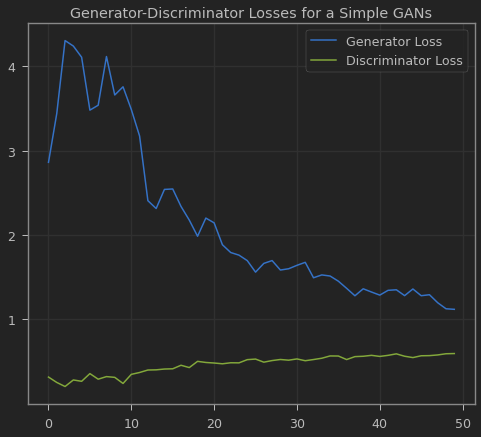

In [19]:
plt.title("Generator-Discriminator Losses for a Simple GANs")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.legend()
plt.show()

In [20]:
save_model = {"Generator" : G.state_dict(),
             "Discriminator" : D.state_dict(),
             "G_Optim": g_optim.state_dict(),
             "D_Optim": d_optim.state_dict()}

torch.save(save_model, "./MODELS/SimpleGANs.ptx")